# Gaussian process lecture

## Brown University, 16 Feb. 2016

### By: Andreas Damianou

Import necessary libraries and modules

In [1]:
%pylab inline

# Import relevant Python libraries
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import numpy as np
import scipy as sp
from scipy.stats import multivariate_normal

# Import the Gaussian process Python package
import GPy

Populating the interactive namespace from numpy and matplotlib


# GPs as infinite dimensional Gaussian distributions 

A Gaussian process (GP) is a collection of random variables, any finite number of which have a joint Gaussian distribution.

Equivalently, a GP can be seen as a stochastic process which corresponds to an infinite dimensional Gaussian distribution.

## Intuition by sampling and plotting Gaussians

Let's first define some plotting functions that we'll use later. 

In [2]:
def gen_Gaussian_samples(mu, sigma, N=200):
    """
    Generate N samples from a multivariate Gaussian with mean mu and covariance sigma
    """
    D = mu.shape[0]
    samples = np.zeros((N,D))
    for i in np.arange(N):
        samples[i,:] = np.random.multivariate_normal(mean=mu, cov=sigma)
    return samples.copy()


def gen_plot_Gaussian_samples(mu, sigma,N=1000):
    """
    Generate N samples from a multivariate Gaussian with mean mu and covariance sigma
    and plot the samples as they're generated
    """
    for i in np.arange(N):
        sample = np.random.multivariate_normal(mean=mu, cov=sigma)
        plt.plot(sample[0],sample[1], '.',color='r',alpha=0.6)
    plt.grid()


def plot_Gaussian_contours(x,y,mu,sigma,N=100):
    """
    Plot contours of a 2D multivariate Gaussian based on N points. Given points x and y are 
    given for the limits of the contours
    """
    X, Y = np.meshgrid(np.linspace(x.min()-0.3,x.max()+0.3,100), np.linspace(y.min()-0.3,y.max()+0.3,N))
    rv = multivariate_normal(mu, sigma)
    Z = rv.pdf(np.dstack((X,Y)))
    plt.contour(X,Y,Z)
    plt.xlabel('x_1')
    plt.ylabel('x_2')

def plot_sample_dimensions(samples, colors=None, markers=None, ms=10):
    """
    Given a set of samples from a bivariate Gaussian, plot them, but instead of plotting them
    x1 vs x2, plot them as [x1 x2] vs ['1', '2']
    """
    N = samples.shape[0]
    D = samples.shape[1]
    
    t=np.array(range(1,D+1))

    for i in np.arange(N):
        if colors is None and markers is None:
            plt.plot(t,samples[i,:], '-o',ms=ms)
        elif colors is None:
            plt.plot(t,samples[i,:], '-o',marker=markers[i],ms=ms)
        elif markers is None:
            plt.plot(t,samples[i,:], '-o',color=colors[i],ms=ms)
        else:
            plt.plot(t,samples[i,:], '-o',color=colors[i],marker=markers[i],ms=ms)
    plt.grid()
    plt.xlim([0.8,t[-1]+0.2])
    plt.ylim([samples.min()-0.3, samples.max()+0.3])
    plt.xlabel('d = {' + str(t) + '}')
    plt.ylabel('[x_d]')
    plt.gca().set_title(str(N) + ' samples from a bivariate Gaussian')


def set_limits(samples):
    plt.xlim([samples[:,0].min()-0.3, samples[:,0].max()+0.3])
    plt.ylim([samples[:,1].min()-0.3, samples[:,1].max()+0.3])


Test the two different ways of plotting a bivariate Gaussian.

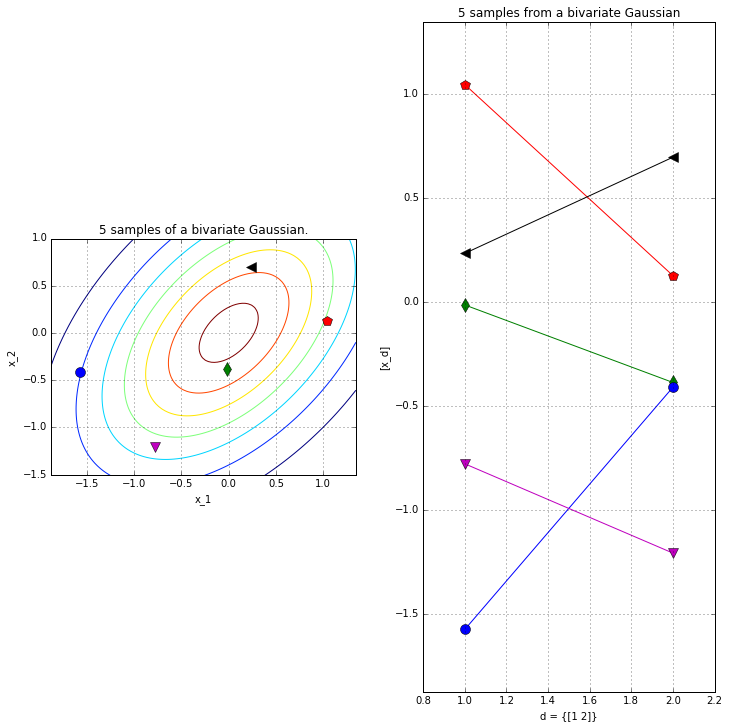

In [3]:
colors = ['r','g','b','m','k']
markers = ['p','d','o','v','<']

N=5 # Number of samples
mu = np.array([0,0])  # Mean of the 2D Gaussian
sigma = np.array([[1, 0.5], [0.5, 1]]); # covariance of the Gaussian


# Generate samples
samples = gen_Gaussian_samples(mu,sigma,N) 


f=figure(figsize=(12,12)); 
ax1=plt.subplot(1, 2, 1,autoscale_on=False, aspect='equal')
set_limits(samples)
plot_Gaussian_contours(samples[:,0],samples[:,1],mu,sigma)

# Plot samples
for i in np.arange(N):
    plt.plot(samples[i,0],samples[i,1], 'o', color=colors[i], marker=markers[i],ms=10)
plt.grid()
plt.gca().set_title(str(N) + ' samples of a bivariate Gaussian.')

ax2=plt.subplot(1, 2, 2,autoscale_on=False, aspect='equal')
plot_sample_dimensions(samples=samples, colors=colors, markers=markers)
#ax2.set(autoscale_on=False, aspect='equal')

Repeat as before, but now we'll plot many samples from two kinds of Gaussians: one which with strongly correlated dimensions and one with weak correlations

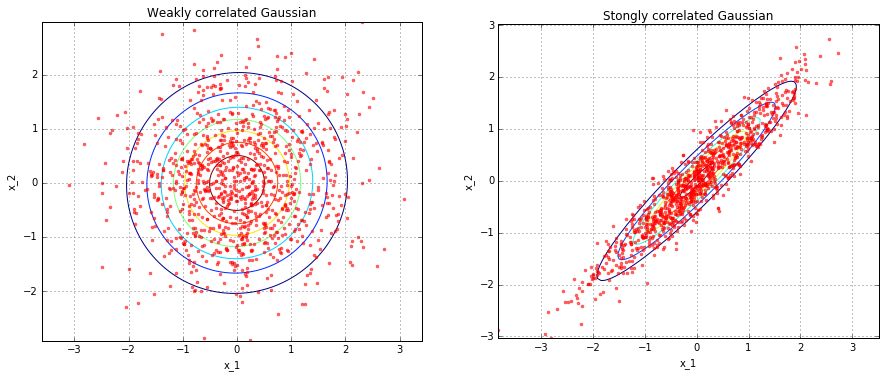

In [4]:
# Plot with contours. Compare a correlated vs almost uncorrelated Gaussian

sigmaUncor = np.array([[1, 0.02], [0.02, 1]]);
sigmaCor = np.array([[1, 0.95], [0.95, 1]]);

f=figure(figsize=(15,15)); 

ax=plt.subplot(1, 2, 1); ax.set_aspect('equal')
samplesUncor=gen_Gaussian_samples(mu,sigmaUncor)
plot_Gaussian_contours(samplesUncor[:,0],samplesUncor[:,1], mu, sigmaUncor)
gen_plot_Gaussian_samples(mu, sigmaUncor)
plt.gca().set_title('Weakly correlated Gaussian')

ax=plt.subplot(1, 2, 2); ax.set_aspect('equal')
samplesCor=gen_Gaussian_samples(mu,sigmaCor)
plot_Gaussian_contours(samplesCor[:,0],samplesCor[:,1], mu, sigmaCor)
gen_plot_Gaussian_samples(mu, sigmaCor)
plt.gca().set_title('Stongly correlated Gaussian')

(-3.5998602496521106, 3.4183884606385022)

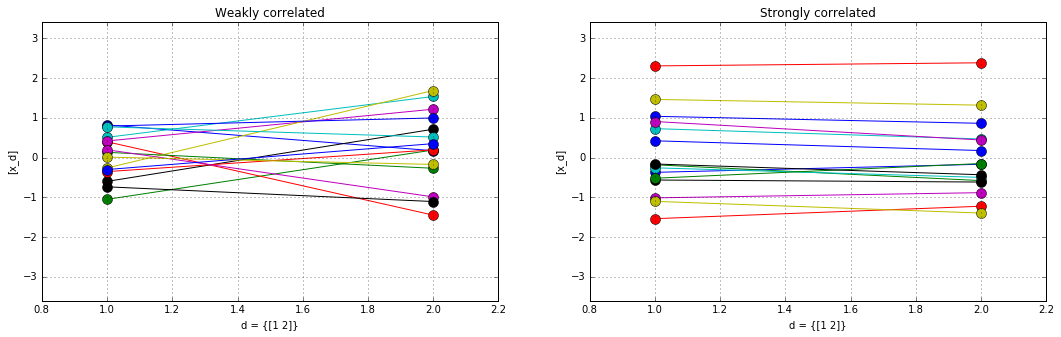

In [5]:
# But let's plot them as before dimension-wise...

f=figure(figsize=(18,5)); 
perm = np.random.permutation(samplesUncor.shape[0])[0::14]

ax1=plt.subplot(1, 2, 1); ax1.set_aspect('auto')
plot_sample_dimensions(samplesUncor[perm,:])
plt.gca().set_title('Weakly correlated')
ax2=plt.subplot(1, 2, 2,sharey=ax1); ax2.set_aspect('auto')
plot_sample_dimensions(samplesCor[perm,:])
plt.gca().set_title('Strongly correlated')
plt.ylim([samplesUncor.min()-0.3, samplesUncor.max()+0.3])

The strongly correlated Gaussian results in more "horizontal" lines in the dimension-wise plot.

More importantly, by using the dimension-wise plot, we are able to plot Gaussians which have more than two dimensions. Below we plot N samples from a D=8-dimensional Gaussian. Because I don't want to write down the full 8x8 covariance matrix, I define a "random" one through a mathematical procedure that is guaranteed to give me back a positive definite and symmetric matrix (i.e. a valid covariance). More on this later.

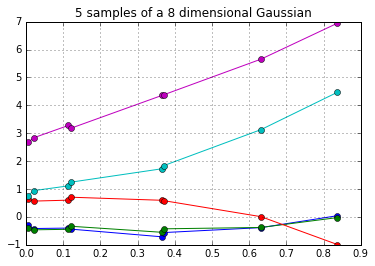

In [6]:
N=5
mu = np.array([0,0,0,0,0,0,0,0])
D = mu.shape[0]

# Generate random covariance matrix
tmp = np.sort(sp.random.rand(D))[:,None]
tmp2 = tmp**np.arange(5)
sigma = 5*np.dot(tmp2,tmp2.T) + 0.005*np.eye(D)

samples = gen_Gaussian_samples(mu,sigma,N)

for i in np.arange(N):
    plt.plot(tmp,samples[i,:], '-o')
plt.grid()

plt.gca().set_title(str(N) + ' samples of a ' + str(D) + ' dimensional Gaussian')

Taking this even further, we can plot samples from a 200-dimensional Gaussian in the dimension-wise plot. 

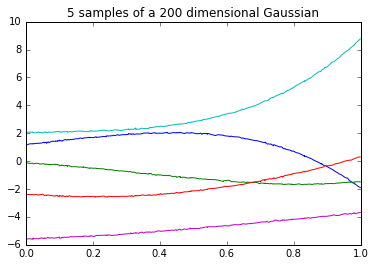

In [7]:
N=5
D=200
mu = np.zeros((D,1))[:,0]

# Generate random covariance matrix
tmp = np.sort(sp.random.rand(D))[:,None]
tmp2 = tmp**np.arange(5)
sigma = 5*np.dot(tmp2,tmp2.T)+ 0.0005*np.eye(D)

samples = gen_Gaussian_samples(mu,sigma,N)

for i in np.arange(N):
    plt.plot(tmp,samples[i,:], '-')

plt.gca().set_title(str(N) + ' samples of a ' + str(D) + ' dimensional Gaussian')

We see that each sample now starts looking like a "smooth" curve. Therefore, we now have a clear intuition as to why a GP can be seen as an *infinite dimensional multivariate Gaussian* which is used as a *prior over functions*, since one sample from a GP is a function.

### Mean and covariance function

Similarly to how a D-dimensional Gaussian is parameterized by its mean vector and its covariance matrix, a GP is parameterized by a mean *function* and a covariance *function*. To explain this, we'll assume (without loss of generality) that the mean function is $\mu(x) = \mathbf{0}$. As for the covariance function, $k(x,x')$, it is a function that receives as input two locations $x,x'$ belonging to the input domain, i.e. $x,x' \in \mathcal{X}$, and returns the value of their co-variance.

In this way, if we have a *finite* set of input locations we can evaluate the covariance function at every pair of locations and obtain a covariance matrix $\mathbf{K}$. We write:
$$
\mathbf{K} = k(\mathbf{X}, \mathbf{X}),
$$
where $\mathbf{X}$ is the collection of training inputs.

More on covariance functions later. For the moment, think of them as kind of a black box.

Importantly, even if we assume that the input domain is inifinte, e.g. $\mathbb{R}$, we can get away with never having to perform infinite number of operations. This is because of the marginalization property of the Gaussian distribution. See below.

## Marginalization and conditioning properties of the Gaussian

### Joint

Let's start with a multivariate Gaussian. Assume that we have a random variable $\mathbf{f}$ which follows a multivariate Gaussian, and we partition its dimensions into two sets, $A,B$. Then, the joint distribution can be written as:
$$
p(\underbrace{f_1, f_2, \cdots, f_s}_{\mathbf{f}_A}, \underbrace{f_{s+1}, f_{s+2}, \cdots, f_N}_{\mathbf{f}_B}) \sim \mathcal{N}(\boldsymbol \mu, \mathbf{K}).
$$
with:
$$
\boldsymbol \mu = 
    \begin{bmatrix}
        \boldsymbol \mu_A \\
      \boldsymbol \mu_B
    \end{bmatrix}
  \; \; \text{and} \; \;
    \mathbf{K} = 
    \begin{bmatrix}
         \mathbf{K}_{A A} & \mathbf{K}_{A B} \\
         \mathbf{K}_{B A} & \mathbf{K}_{B B}
    \end{bmatrix}
$$

### Marginal

And the *marginal* distribution can be written as:

$$
p(\mathbf{f}_A, \mathbf{f}_B)  \sim \mathcal{N}(\boldsymbol \mu, \mathbf{K}). \text{ Then:} \\
p(\mathbf{f}_A)  = \int_{\mathbf{f}_B} p(\mathbf{f}_A, \mathbf{f}_B) \text{d} \mathbf{f}_B =
       \mathcal{N}(\boldsymbol \mu_A, \mathbf{K}_{A A}) %\\
% p(\mathbf{f}_B)  = \int_{\mathbf{f}_A} p(\mathbf{f}_A, \mathbf{f}_B) \text{d} \mathbf{f}_A = 
%        \mathcal{N}(\boldsymbol \mu_B,\mathbf{K}_{B B})
$$

The marginalization property means that the training data that have and any (potentially infinite in number) test data $f_*$ that we have not seen (yet), follow a (potentially infinite) Gaussian distribution with mean and covariance:

$$
  \boldsymbol \mu_{\infty} = 
    \begin{bmatrix}
      \boldsymbol \mu_{\!_\mathbf{X}} \\
      \cdots \\
      \cdots
    \end{bmatrix}
  \; \; \text{and} \; \;
    \mathbf{K}_{\infty} = 
    \begin{bmatrix}
      \mathbf{K}_{\!_\mathbf{X} \!_\mathbf{X}} & \cdots \\
      \cdots & \cdots
    \end{bmatrix}
$$

where $\mathbf{X}$ is training inputs and $\mathbf{K}_{XX}$ is the covariance matrix constructing by evaluating the covariance *function* at all given inputs. 

So, in the Gaussian process case (assuming 0 mean) we have a joint Gaussian distribution of the training and the (potentially infinite!) test data:

$$
\begin{bmatrix}\mathbf{f} \\ \mathbf{f}^*\end{bmatrix} \sim \mathcal{N}\left(\mathbf{0}, \begin{bmatrix} \mathbf{K} & \mathbf{K}_\ast \\ \mathbf{K}_\ast^\top & \mathbf{K}_{\ast,\ast}\end{bmatrix}\right)
$$

Here, $\mathbf{K}_\ast$ is the (cross)-covariance matrix obtained by evaluating the covariance function in pairs of training inputs $\mathbf{X}$ and test inputs $\mathbf{X_*}$, ie.

$$
\mathbf{K}_\ast = k(\mathbf{X}, \mathbf{X}_*) .
$$

Similarly:

$$
\mathbf{K}_{\ast\ast} = k(\mathbf{X}_*, \mathbf{X}_*) .
$$

### Conditional 

Interestingly, conditioning a multivariate Gaussian to obtain the posterior distribution also yields a Gaussian:
Again, if
$$
p(\mathbf{f}_A, \mathbf{f}_B)  \sim \mathcal{N}(\boldsymbol \mu, \mathbf{K}). \; \; \text{Then:} \\
p(\mathbf{f}_A | \mathbf{f}_B) = \mathcal{N}(\boldsymbol \mu_A + \mathbf{K}_{AB} \mathbf{K}^{-1}_{BB} (\mathbf{f}_B - \boldsymbol \mu_B), \mathbf{K}_{AA} - \mathbf{K}_{AB}\mathbf{K}_{BB}^{-1}\mathbf{K}_{BA})% \\
% p(\mathbf{f}_B | \mathbf{f}_A) = \mathcal{N}(\cdots, \cdots)
$$

In the GP context this can be used for inter/extrapolation. Assume that we have a function $f$ with input domain $\mathcal{X} = \mathbb{R}$ and we set a GP prior on $f$ (so, now we use $f$ to denote function evaluations, rather than random variables). Also assume that we have a training set $\mathbf{X} = [x_1, x_2, \dots x_N]$. Then, we can condition on the function ouputs evaluated on the training set in order to perform inference for the function value at *any* input location $x_* \in \mathbb{R}$. This conditioning means finding the GP posterior *process*:

$$
p(\mathbf{f_*} | \mathbf{f_1}, \cdots, \mathbf{f_N}) = 
p(f(x_*) | f(x_1), \cdots, f(x_N)) \\
         \sim \mathcal{N}(\mathbf{K}_*^\top \mathbf{K}^{-1} \mathbf{f}\; , \; \mathbf{K}_{*,*} - \mathbf{K}_*^\top \mathbf{K}^{-1} \mathbf{K}_*)
$$

Remember, the test inputs $\mathbf{X}_*$ appear in the above expression inside $\mathbf{K}_*$ and $\mathbf{K}_{**}$.

# Noise model

As is standard in probabilistic regression, we assume a noise model. We take:

$$
y = f(x) + \epsilon
$$

where:

$$
f \sim \mathcal{GP}(0, k(x,x'))
$$

and

$$
\epsilon \sim \mathcal{N}(0,\sigma^2 I)
$$

where non-bold symbols now denote single elements from the training vectors.

The assumption about Gaussian noise says that the *training data* $(x,y) \in (\mathbf{X}, \mathbf{Y})$ are related by a function $f$ whose output is then corrupted by Gaussian noise (i.e. we have noisy observations).

Now, for a test point $x_*$ we want to compute its output on the observed space, i.e. we want to compute $y_*$. Building on the noise model and the previously shown expressions, the posterior for the test outputs is given by:

$$
\mathbf{y}^* | \mathbf{y}, \mathbf{x}, \mathbf{x_*} \sim \mathcal{N}(\boldsymbol \mu_{\text{pred}},\mathbf{K}_{\text{pred}})
$$
with  
$$
\boldsymbol \mu_{\text{pred}} = \mathbf{K}_*^\top \left[\mathbf{K} + \sigma^2 \mathbf{I}\right]^{-1} \mathbf{y}
$$
and 
$$
\mathbf{K}_{\text{pred}} = \mathbf{K}_{*,*} - \mathbf{K}_*^\top \left[\mathbf{K} + \sigma^2 \mathbf{I}\right]^{-1} \mathbf{K}_*.
$$

# Covariance functions

# Implementation!

Let's finally implement our GP framework.



In [2]:
class CovFunctions(object):
    def __init__(self, covType, theta):
        self.covType = covType
        self.theta = theta
        if covType == 'linear':
            self.compute = self.linear
        elif covType == 'RBF':
            self.compute = self.RBF
    
    def set_theta(self, theta):
        self.theta = theta
    
    def get_theta(self):
        return self.theta
    
    def linear(self, x,x2=None):
        if x2 is None:
            return np.dot(x, x.T)*self.theta
        else:
            return np.dot(x, x2.T)*self.theta
    
    def RBF(self, x, x2=None):
        """
        Compute the Euclidean distance between each row of X and X2, or between
        each pair of rows of X if X2 is None.
        """
        variance = self.theta[0]
        lengthscale = self.theta[1]
        if x2 is None:
            xsq = np.sum(np.square(x),1)
            r2 = -2.*np.dot(x,x.T) + (xsq[:,None] + xsq[None,:])
            r = np.sqrt(r2)/lengthscale
        else:
            x1sq = np.sum(np.square(x),1)
            x2sq = np.sum(np.square(x2),1)
            r2 = -2.*np.dot(x, x2.T) + x1sq[:,None] + x2sq[None,:]
            r = np.sqrt(r2)/lengthscale

        return variance * np.exp(-0.5 * r**2)

class GP(object):
    def __init__(self, X, Y, sigma2, covType, theta):
        self.X = X
        self.Y = Y
        self.N = self.X.shape[0]
        self.sigma2 = sigma2
        self.kern = CovFunctions(covType, theta)
        self.K = self.kern.compute(X)
    
    def get_params(self):
        return np.hstack((self.sigma2, self.k.get_theta))
    
    def set_params(self, params):
        self.sigma2 = params[0]
        self.kern.set_theta(params[1:])
    
    def update_stats(self):
        self.K = self.kern.compute(self.X)
        self.Kinv = np.linalg.inv(self.K+self.sigma2*np.eye(self.N))
        self.logdet = np.linalg.det(self.K+self.sigma2*np.eye(self.N))
        self.KinvY = np.dot(self.Kinv, self.Y)
        self.YKinvY = (self.Y*self.KinvY).sum()
    
    def likelihood(self, params):
        return -0.5*(self.N*np.log(2*np.pi) + self.logdet + self.YKinvY)
    
    def objective(self, params):
        self.set_params(params)
        self.update_stats()
        return -self.likelihood(params)
    
    def posterior(self, x_star):
        self.update_stats()
        K_starstar = self.kern.compute(x_star, x_star)
        K_star = self.kern.compute(self.X, x_star)
        KinvK_star = np.dot(self.Kinv, K_star)
        mu_pred = np.dot(KinvK_star.T, self.Y)
        K_pred = K_starstar - np.dot(KinvK_star.T, K_star)
        return mu_pred, K_pred

Testing:

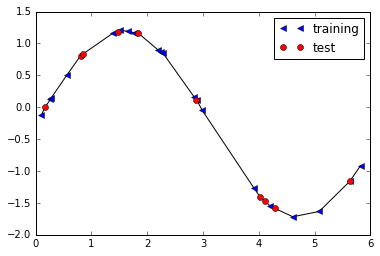

In [20]:
N=20 # number of training points
Nstar = 10 # number of test points

# create toy data
X = np.sort(np.random.rand(N+Nstar, 1) * 6 , axis=0)
Y = np.sin(X) + np.random.randn(*X.shape) * 0.008

# split data into training and test set
perm = np.random.permutation(X.shape[0])
Xtr = X[np.sort(perm[0:N],axis=0),:]
Ytr = Y[np.sort(perm[0:N],axis=0),]
X_star = X[np.sort(perm[N:N+Nstar],axis=0),:]
Y_star = Y[np.sort(perm[N:N+Nstar],axis=0),:]

# Normalize data to be 0 mean and 1 std
Ymean = Ytr.mean()
Ystd = Ytr.std()
Ytr-=Ymean
Ytr/=Ystd
Y_star -= Ymean
Y_star /= Ystd

# plot data
plt.plot(X,(Y-Ymean)/Ystd, 'k-')
plt.plot(Xtr,Ytr, 'b<',label='training')
plt.plot(X_star,Y_star, 'ro',label='test')
plt.legend()



In general, we want a function that plots the fit showing the mean and variance:

In [26]:
def plot_fit(x,y,mu,var):
    plt.plot(x,y, 'k-o',label='true')
    plt.plot(x,mu, 'b-<',label='predicted')
    plt.plot(x, mu+2*np.sqrt(var), 'r--',label='var')
    plt.plot(x, mu-2*np.sqrt(var), 'r--')
    plt.legend()

Now we'll define two GP models, one with linear and one with RBF cov. function. We'll use them to predict the training and the test data.

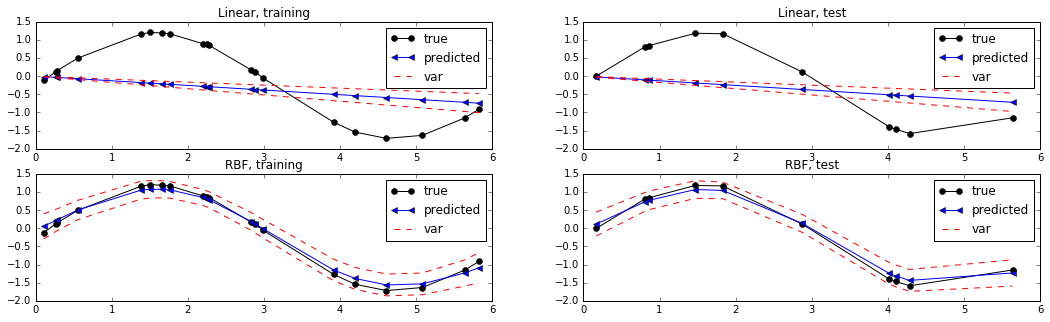

In [27]:
g_lin = GP(Xtr, Ytr, 0.1, 'linear', 2)
g_rbf = GP(Xtr, Ytr, 0.1, 'RBF', np.array([1,2]))

mu_lin_tr,var_lin_tr = g_lin.posterior(Xtr)
mu_rbf_tr,var_rbf_tr = g_rbf.posterior(Xtr)

mu_lin_star,var_lin_star = g_lin.posterior(X_star)
mu_rbf_star,var_rbf_star = g_rbf.posterior(X_star)


f=figure(figsize=(18,5)); 
ax=plt.subplot(2, 2, 1); ax.set_aspect('auto')
plot_fit(Xtr, Ytr, mu_lin_tr, np.diag(var_lin_tr)[:,None])
plt.gca().set_title('Linear, training')

ax=plt.subplot(2, 2, 2); ax.set_aspect('auto')
plot_fit(X_star, Y_star, mu_lin_star, np.diag(var_lin_star)[:,None])
plt.gca().set_title('Linear, test')

ax=plt.subplot(2, 2, 3); ax.set_aspect('auto')
plot_fit(Xtr, Ytr, mu_rbf_tr, np.diag(var_rbf_tr)[:,None])
plt.gca().set_title('RBF, training')

ax=plt.subplot(2, 2, 4); ax.set_aspect('auto')
plot_fit(X_star, Y_star, mu_rbf_star, np.diag(var_rbf_star)[:,None])
plt.gca().set_title('RBF, test')

#plt.plot(Xtr, mu_lin, 'x-')
#plt.plot(Xtr, Ytr, 'ro-')